# NEUSCI440 Toolkit tutorial

Welcome to this tutorial on the toolkit developed for NEUSCI440 `neuscitk`! This Jupyter notebook will guide you through the main features and functionalities of the package, helping you to apply computational methods to the data you collect in lab.  

## What is this toolkit?
This toolkit is a Python package specifically designed for NEUSCI440. It provides a set of tools to work with neuroscience data, particularly focusing on:
1. Loading and managing LabChart datasets
2. Performing spike sorting on raw voltage traces
3. Analyzing waveform characteristics
4. Applying various filters to neuronal signals
5. Calculating firing rates from spike trains

The goal of the toolkit is three fold:
* Simplify complex neuroscience data analysis tasks
* Provide a consistent interface for working with data
* Allow you to focus on interpreting results rather than implementing low-level algorithms

We hope that by providing the tools up front you can start to ask interesting questions of your data as soon as possible (with the help of this tutorial).

## What we'll cover
In this tutorial, we'll walk through
1. Importing the toolkit and exploring LabChart data
2. Performing spike sorting on raw voltage traces
3. Analyzing sorted spikes and their characteristics
4. Applying filters to neuronal signals
5. Calculating and visualizing firing rates

By the end of this tutorial, you'll have a solid foundation for using the toolkit to work with your data, which will be highly valuable for creating awesome lab reports and future research endeavors.

Let's get started by importing the necessary modules and exploring our first dataset!

## Section 1: Setup and Loading Datasets
Many functions in `neuscitk` take `numpy` arrays as inputs, and since we will often want to visualize those arrays we will also need `matplotlib`. You can use any alias you want (or none) for `neuscitk` but for this tutorial and in class we will use `ntk` 

In [58]:
import neuscitk as ntk
import numpy as np
import matplotlib.pyplot as plt

In NEUSCI302 you will be collecting your data in LabChart. LabChart is designed to have recording and analysis be self-contained. This is okay for asking basic questions, but part of this course is getting closer to your data, which will open up more sophisticated types of analyses. To load your LabChart data into Python, you first must export your LabChart data as a MATLAB file (`.mat`). If you try and use the LabChart proprietary file format `.adicht`, `neuscitk` won't accept it.

After you've exported your file as a `.mat`, we can load it by passing the file path to the `ntk.LabChartDataset` class.

In [59]:
dataset = ntk.LabChartDataset('/Users/jeremyschroeter/Desktop/neusci440/assets/datasets/test_2ch.mat')

The `LabChartDataset` class provides methods for getting specific recordings from your dataset, as well as features of those recordings such as the sample rate and the number of channels. Each single recording is referred to as a "block". This departs from the LabChart notion of "pages", but unfortunately LabChart does not export the page information. Instead, each subsequent recording is considered the next "block" in the dataset, irrespective of what it is within a page. See the way the recordings are labeled below to see how `LabChartDataset` accesses your data.


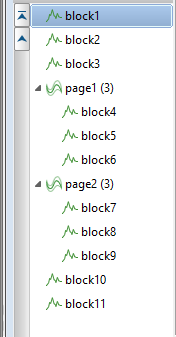

If you want to include page information you have to add this manually by creating a dictionary that maps from pages to blocks, and then pass that dictionary to  `dataset.organize_pages`

In [60]:
page_map = {
    'spontaneous' : [1, 2],
    'page_1' : [3],
}

dataset.organize_by_pages(page_map)

**NOTE** Even though Python uses zero-indexing, we start the block-ids at 1 to be consistent with LabChart.

You can then access a page by using `dataset.get_page` which takes the name you gave your page as input and returns a dictionary with the associated blocks.

In [61]:
spontaneous_data = dataset.get_page('spontaneous')
print(spontaneous_data)

{'block_1': array([[ 0.01     ,  0.0065625, -0.0025   , ..., -0.0084375, -0.011875 ,
        -0.00625  ],
       [ 0.0153125,  0.010625 , -0.0021875, ..., -0.0109375, -0.015    ,
        -0.0084375]], dtype=float32), 'block_2': array([[-0.0034375,  0.0015625,  0.0046875, ...,  0.0040625,  0.0096875,
         0.0065625],
       [-0.00375  ,  0.0028125,  0.006875 , ...,  0.005625 ,  0.0140625,
         0.0109375]], dtype=float32)}


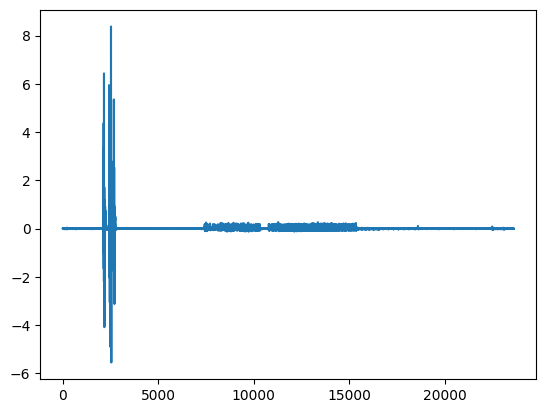

In [63]:
plt.plot(spontaneous_data['block_1'][0])

Each block will have shape `(n_channels, n_timepoints)` if there are more than 1 channels or `(n_timepoints,)` if there is only 1.

It is encouraged to organize all the blocks in your dataset with pages. Pages can be named whatever they want so they can be given names relating to the experiments you performed, 'spontaneous activity' for example.

In [ ]:
# page_map = {
#     'setting_up' : [1],
#     'spontaneous_activity' : [2, 3],
#     'stimulus_1' : [4, 5, 6],
#     'stimulus_2' : [7, 8, 9],
#     'extra' : [10, 11]
# }

# dataset.organize_pages(page_map)

However, if you want to access individual blocks, you can do so by passing a list of the blocks you want to `dataset.get_blocks`.

In [66]:
block1 = dataset.get_block(1)
print(block1)

[[ 0.01       0.0065625 -0.0025    ... -0.0084375 -0.011875  -0.00625  ]
 [ 0.0153125  0.010625  -0.0021875 ... -0.0109375 -0.015     -0.0084375]]


The `LabChartDataset` class also provides a method for concatenating blocks into a single array. This is useful for when you want to perform analyses on a subset of your data, or when you want to visualize your data in a single plot. Spike sorting is one such example where you may want to concatenate multiple blocks into a single array to identify neurons which are consistent across multiple recordings. To concatenate blocks you can use `dataset.concat_blocks` which takes a list of block ids as input.

In [68]:
three_blocks = dataset.concat_blocks([1, 2, 3])
print(three_blocks.shape)

(2, 80000)


Finally, you can easily access the sample rate for your dataset using `dataset.fs`.

It is highly encouraged not to use different sample rates across your dataset but if you do `dataset.fs` will give you the sample rate for each block as an array, otherwise it will just return an integer.

In [69]:
print(dataset.fs)

1000.0


## Section 2: Spike Sorting

When we record from the extracellular environment, the voltage trace that we obtain almost always contains contributions from more than a single neuron. The problem of disentangling and isolating the contributing signals, at least during an action potential, is known as *spike sorting*. Performing spike sorting on your data is usually the first step when beginning to work with our data, and is a necesarry prerequisite for many downstream analyses, such as analyzing an individual neurons action potential waveform for example.

In this tutorial we will not go over how the particular spike sorting algorithm implemented in `neuscitk` works, just show how you can use it. We *will* learn how it works in class.

To begin spike sorting your data you can pass a numpy array into the `ntk.sort_spikes` function along with its sample rate. The function also takes a few optional arguments, however in most cases the default values will work well.

To demonstrate let's load a dataset and sort the spikes from the first block. Let's plot the first block before hand to see what it looks like.

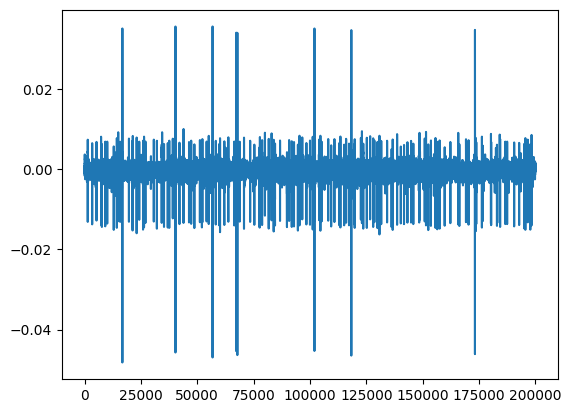

In [70]:
dataset = ntk.LabChartDataset('/Users/jeremyschroeter/Desktop/neusci440/assets/datasets/ntk_tut_data.mat')
block = dataset.get_block(1)
plt.plot(block)

In [79]:
sorting_results = ntk.sort_spikes(block, fs=dataset.fs)

The `sort_spikes` function returns a `SortedSpikes` object which provides methods for visualizing the separated neurons, as well as accessing the spike waveforms and spike times of the neurons it isolated. The `SortedSpikes` object also provides a method for plotting all of the sorted spikes, which can be useful for visualizing the quality of the spike sorting. The fainter traces are the individual spikes, while the darker traces are the average spike waveform for each cluster.

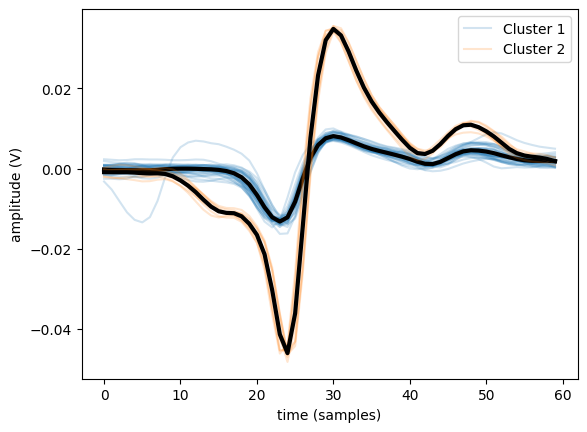

In [80]:
sorting_results.plot_clusters()

To access the spike waveforms and spike times you can use the `SortedSpikes.get_cluster_waveforms` and `SortedSpikes.get_cluster_spike_times` methods respectively. The `get_cluster_waveforms` method returns a numpy array with shape `(n_spikes, n_timepoints)` and the `get_cluster_spike_times` method returns a numpy array of length `n_spikes`.

(33, 60)


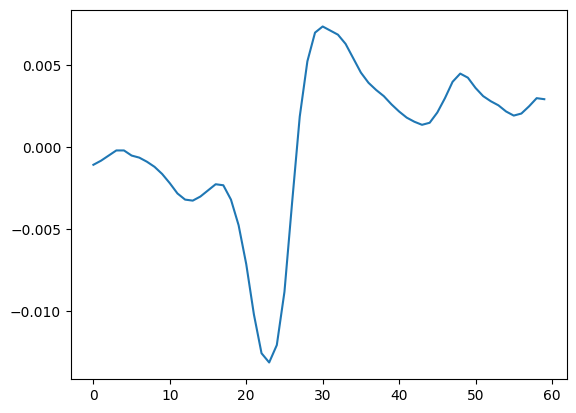

In [81]:
cluster_1_waveforms = sorting_results.get_cluster_waveforms(1)
print(cluster_1_waveforms.shape)
plt.plot(cluster_1_waveforms[0])
plt.show()

In [76]:
cluster_1_spike_times = sorting_results.get_cluster_spike_times(1)
print(cluster_1_spike_times)

[  1436   7345  14950  19709  26404  27025  30735  39155  43930  55101
  63793  73471  80023  82978  90752  95348  96583 108095 110848 113500
 122583 123051 126694 128567 130820 134207 138650 151473 155674 165770
 169199 176263 198289]


### When spike sorting goes wrong

It looks like the algorithm did a good job at picking out the two neurons in the data. However, this may not always be the case. In that case you have three options, you can try tuning the parameters of the `sort_spikes` function, you can hand pick the spikes by selecting the points in their principal component space, or you can do a combination of the two. Don't worry if you don't know what all that means exactly, ***don't worry*** the actual usage is fairly intuitive.

Let's say we weren't happy with our spike sorting and wanted to do it manually. To do this we can call the `SortedSpikes.hand_pick_clusters` method which will open a plot that allows you to select the spikes you want to include in each cluster. You can then close the plot and the clusters will be updated.

In [82]:
sorting_results.hand_pick_clusters()

The `SortedSpikes` object should have updated automatically, and you can access the new waveforms and spike times by calling the `get_waveforms` and `get_cluster_spike_times` methods again. Let's plot the new clusters.

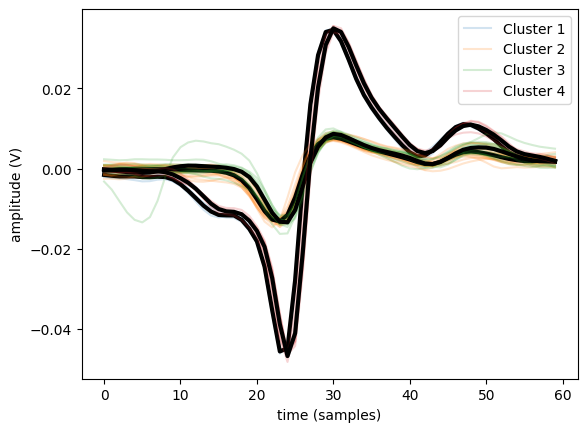

In [83]:
sorting_results.plot_clusters()

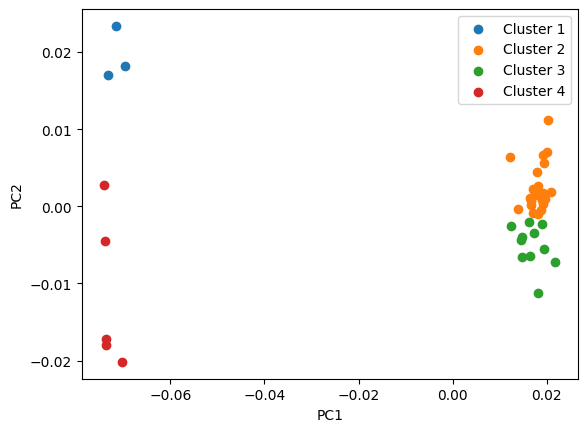

In [84]:
sorting_results.plot_pca()

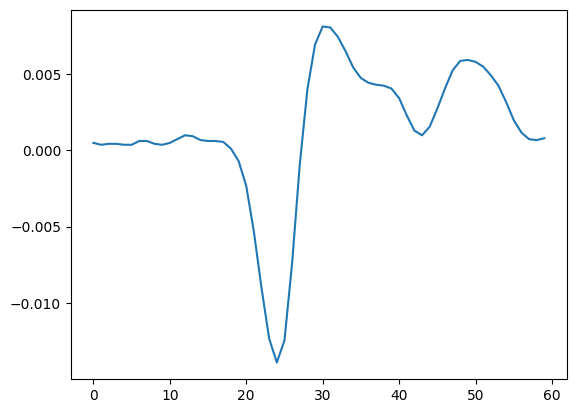

In [85]:
cluster_3_waveforms = sorting_results.get_cluster_waveforms(3)
plt.plot(cluster_3_waveforms[0])

Sometimes the `sort_spikes` will correctly identify the number of neurons in the data but will shift the same spike in time. Again, one method to deal with this is to play with the parameters of the function, but another is to use the `SortedSpikes.shift_clusters` method. This method allows you to choose a cluster and shift its spike times by a certain number of samples, and then have you hand pick the new set of spikes. It will also remove any duplicates that may have been created.

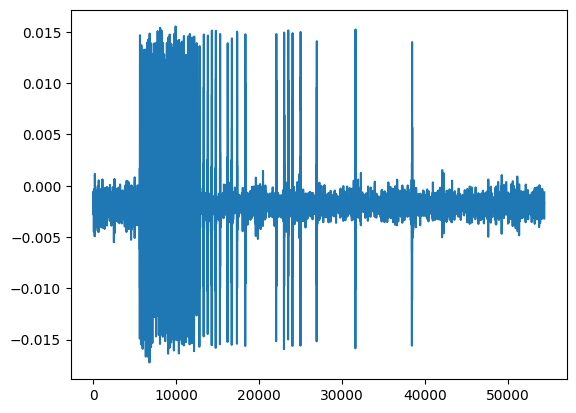

In [86]:
dataset = ntk.LabChartDataset("/Users/jeremyschroeter/Desktop/neusci440/assets/datasets/PhasicDataReal.mat")
block = dataset.get_block(1)
plt.plot(block)

In [87]:
spikes = ntk.sort_spikes(block, dataset.fs)

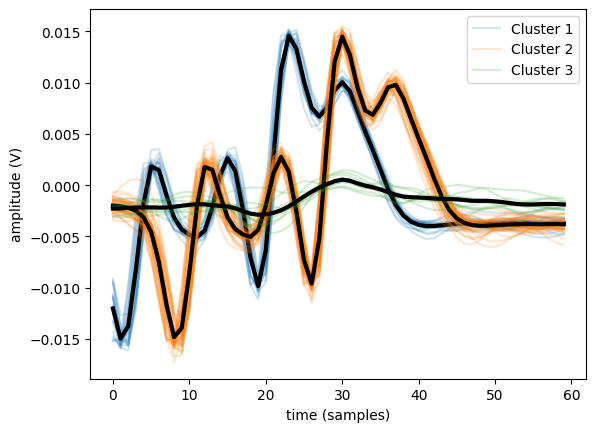

In [88]:
spikes.plot_clusters()

In [89]:
spikes.shift_clusters(1, 7)

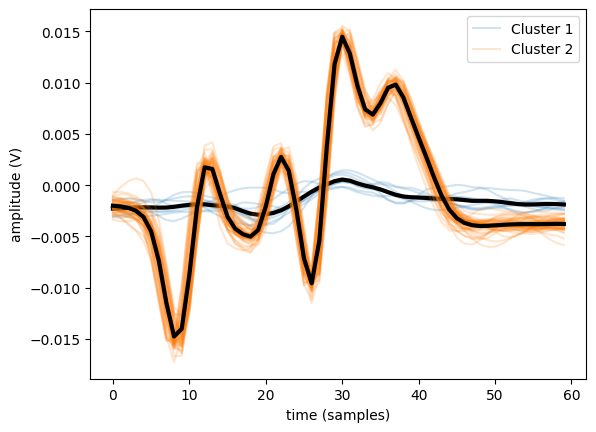

In [90]:
spikes.plot_clusters()

From this point we can go on to compute the firing rates of the neurons, or we can analyze the waveform characteristics of the neurons. Let's do the former.

## Section 3: Converting to Firing Rates

Depending on the particular analysis we are performing we may or may not care about the attributes of the neurons action potential waveform. For example, we may be interested in analyzing the firing rate of a neuron after we present some sort of stimulus. We will talk more about the motivation of using firing rates instead of raw voltage data in class. `neuscitk` provides methods for going extracting these firing rates very easily.

To start we can take our individual neurons and get their spike train. A spike train is an array where each element is a timepoint from our recording and contains a 0 if no AP occured at that time point or a 1 if an AP *did* occur. To get a spike train we can use `spikes.get_spike_train()` and give it the cluster number we want.

In [ ]:
cluster_spikes = spikes.get_spike_train(2)
plt.plot(cluster_spikes)

A comman way to visualize spike train is with a raster plot. We can make one of these if we pass our spike times to `plt.eventplot()`

In [ ]:
cluster_spike_times = spikes.get_cluster_spike_times(2)
plt.eventplot(cluster_spike_times)

There are several ways to approximate a firing rate from a spike train and we will discuss these in detail in class. For the impatiently curious, most of these methods come down to taking a weighted moving average over our spike train, and the different weightings provide different shapes.

To convert your spike train to a firing rate you can use `ntk.FiringRateConverter` and provide it with your sample rate. `FiringRateConverter` takes a couple parameters. The `filter_type` parameter will control the shape of your moving average, and the time constant will control its width. Feel free to play with the different parameters to see how it changes things.

In [ ]:
firing_rate_converter = ntk.FiringRateConverter(dataset.fs, filter_type='exponential', time_constant=0.05)
firing_rate = firing_rate_converter.apply(cluster_spikes)
plt.plot(firing_rate)